# Random forest parameter-tuning
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Validation curves](#Validation-curves)
3. [KS-test tuning](#KS-test-tuning)

In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [2]:
from __future__ import division, print_function
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns
import scipy.stats as stats

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid, KFold, ShuffleSplit

import composition as comp

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = defaultdict()
for i, composition in enumerate(['light', 'heavy', 'total']):
    color_dict[composition] = sns.color_palette('muted').as_hex()[i]
%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data preprocessing
1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [3]:
sim_train, sim_test = comp.preprocess_sim(return_energy=True)

/home/jbourbeau/cr-composition/composition/load_dataframe.py:56: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))
/home/jbourbeau/cr-composition/composition/load_dataframe.py:57: RuntimeWarning: divide by zero encountered in log10
  df['log_NHits_1_30'] = np.nan_to_num(np.log10(df['NHits_1_30']))


sim quality cut event flow:
              lap_reco_success:  0.612  0.612
                    lap_zenith:  0.718  0.578
                 num_hits_1_30:  0.624  0.563
                     IT_signal:  0.231  0.221
                max_qfrac_1_30:  0.775  0.221
               lap_containment:  0.589  0.172
              energy_range_lap:  0.415  0.117



Features selected = ['lap_cos_zenith', 'log_NChannels_1_30', 'nchannels_nhits_ratio', 'lap_rlogl', 'log_NHits_1_30', 'log_s125', 'lap_beta']

Number training events = 145932
Number testing events = 62543


In [4]:
X_test_data, energy_test_data = comp.preprocess_data(return_energy=True)


Features selected = ['lap_log_energy', 'lap_cos_zenith', 'log_NChannels_1_30', 'nchannels_nhits_ratio', 'lap_rlogl', 'log_NHits_1_30', 'log_s50', 'log_s125']

Number testing events = 3253341


## Validation curves
(10-fold CV)

### Maximum depth

In [6]:
pipeline = comp.get_pipeline('xgboost')
param_range = np.arange(1, 212, 20)
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=sim_train.X, 
                y=sim_train.y, 
                param_name='classifier__n_estimators', 
                param_range=param_range,
                cv=3,
                scoring='accuracy',
                verbose=2,
                n_jobs=15)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

[CV] classifier__n_estimators=1 ......................................
[CV] classifier__n_estimators=21 .....................................
[CV] classifier__n_estimators=41 .....................................
[CV] classifier__n_estimators=61 .....................................
[CV] classifier__n_estimators=81 .....................................
[CV] classifier__n_estimators=101 ....................................
[CV] classifier__n_estimators=121 ....................................
[CV] classifier__n_estimators=141 ....................................
[CV] classifier__n_estimators=161 ....................................
[CV] classifier__n_estimators=181 ....................................
[CV] classifier__n_estimators=201 ....................................
[CV] classifier__n_estimators=1 ......................................
[CV] classifier__n_estimators=21 .....................................
[CV] classifier__n_estimators=41 .....................................
[CV] c

[Parallel(n_jobs=15)]: Done  17 out of  33 | elapsed: 14.2min remaining: 13.4min


[CV] ........................... classifier__n_estimators=121 -   1.0s
[CV] classifier__n_estimators=201 ....................................
[CV] ........................... classifier__n_estimators=121 -   1.5s
[CV] ........................... classifier__n_estimators=121 -   1.7s
[CV] ........................... classifier__n_estimators=201 -   1.2s
[CV] ........................... classifier__n_estimators=141 -   3.0s
[CV] ........................... classifier__n_estimators=101 -   3.5s
[CV] ............................ classifier__n_estimators=81 -   2.0s
[CV] ........................... classifier__n_estimators=161 -   1.4s
[CV] ........................... classifier__n_estimators=161 -   1.4s
[CV] ........................... classifier__n_estimators=181 -   1.3s
[CV] ........................... classifier__n_estimators=181 -   1.2s
[CV] ........................... classifier__n_estimators=201 -   1.8s
[CV] ........................... classifier__n_estimators=161 -   0.8s
[CV] .

[Parallel(n_jobs=15)]: Done  33 out of  33 | elapsed: 27.3min finished


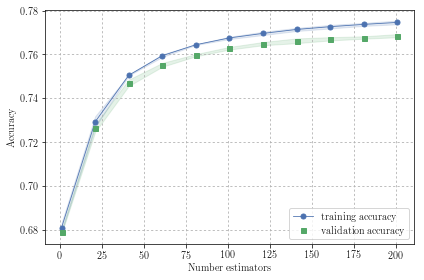

In [13]:
plt.plot(param_range, train_mean, 
         color='b', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='b')

plt.plot(param_range, test_mean, 
         color='g', linestyle='None', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='g')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Number estimators')
plt.ylabel('Accuracy')
# plt.ylim([0.7, 0.8])
# plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-validation_curve_min_samples_leaf.png', dpi=300)
plt.show()

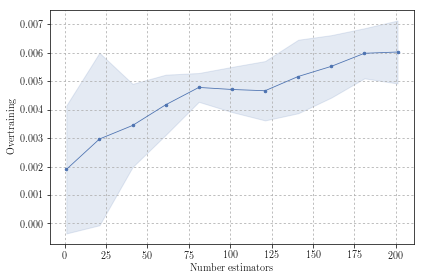

In [14]:
diff = train_mean-test_mean
diff_std = np.sqrt(train_std**2 + test_std**2)

plt.plot(param_range, diff, 
         color='b', marker='.', 
         markersize=5)

plt.fill_between(param_range,
                 diff + diff_std,
                 diff - diff_std,
                 alpha=0.15, color='b')


plt.grid()
plt.xlabel('Number estimators')
plt.ylabel('Overtraining')
# plt.ylim([0.7, 0.8])
# plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-validation_curve_min_samples_leaf.png', dpi=300)
plt.show()

### Max features

[CV] classifier__max_features=1 ......................................
[CV] classifier__max_features=2 ......................................
[CV] classifier__max_features=3 ......................................
[CV] classifier__max_features=4 ......................................
[CV] classifier__max_features=5 ......................................
[CV] classifier__max_features=6 ......................................
[CV] classifier__max_features=7 ......................................
[CV] classifier__max_features=8 ......................................
[CV] classifier__max_features=9 ......................................
[CV] classifier__max_features=1 ......................................
[CV] classifier__max_features=2 ......................................
[CV] classifier__max_features=3 ......................................
[CV] classifier__max_features=4 ......................................
[CV] classifier__max_features=5 ......................................
[CV] c

[Parallel(n_jobs=20)]: Done  45 out of  90 | elapsed:  3.0min remaining:  3.0min


[CV] ............................. classifier__max_features=9 -   2.0s
[CV] classifier__max_features=3 ......................................
[CV] ............................. classifier__max_features=4 -   2.2s
[CV] classifier__max_features=4 ......................................
[CV] ............................. classifier__max_features=5 -   0.9s
[CV] classifier__max_features=5 ......................................
[CV] ............................. classifier__max_features=7 -   1.0s
[CV] classifier__max_features=6 ......................................
[CV] ............................. classifier__max_features=8 -   2.9s
[CV] classifier__max_features=7 ......................................
[CV] ............................. classifier__max_features=6 -   2.8s
[CV] classifier__max_features=8 ......................................
[CV] ............................. classifier__max_features=1 -   0.5s
[CV] classifier__max_features=9 ......................................
[CV] .

[Parallel(n_jobs=20)]: Done  90 out of  90 | elapsed:  5.2min finished


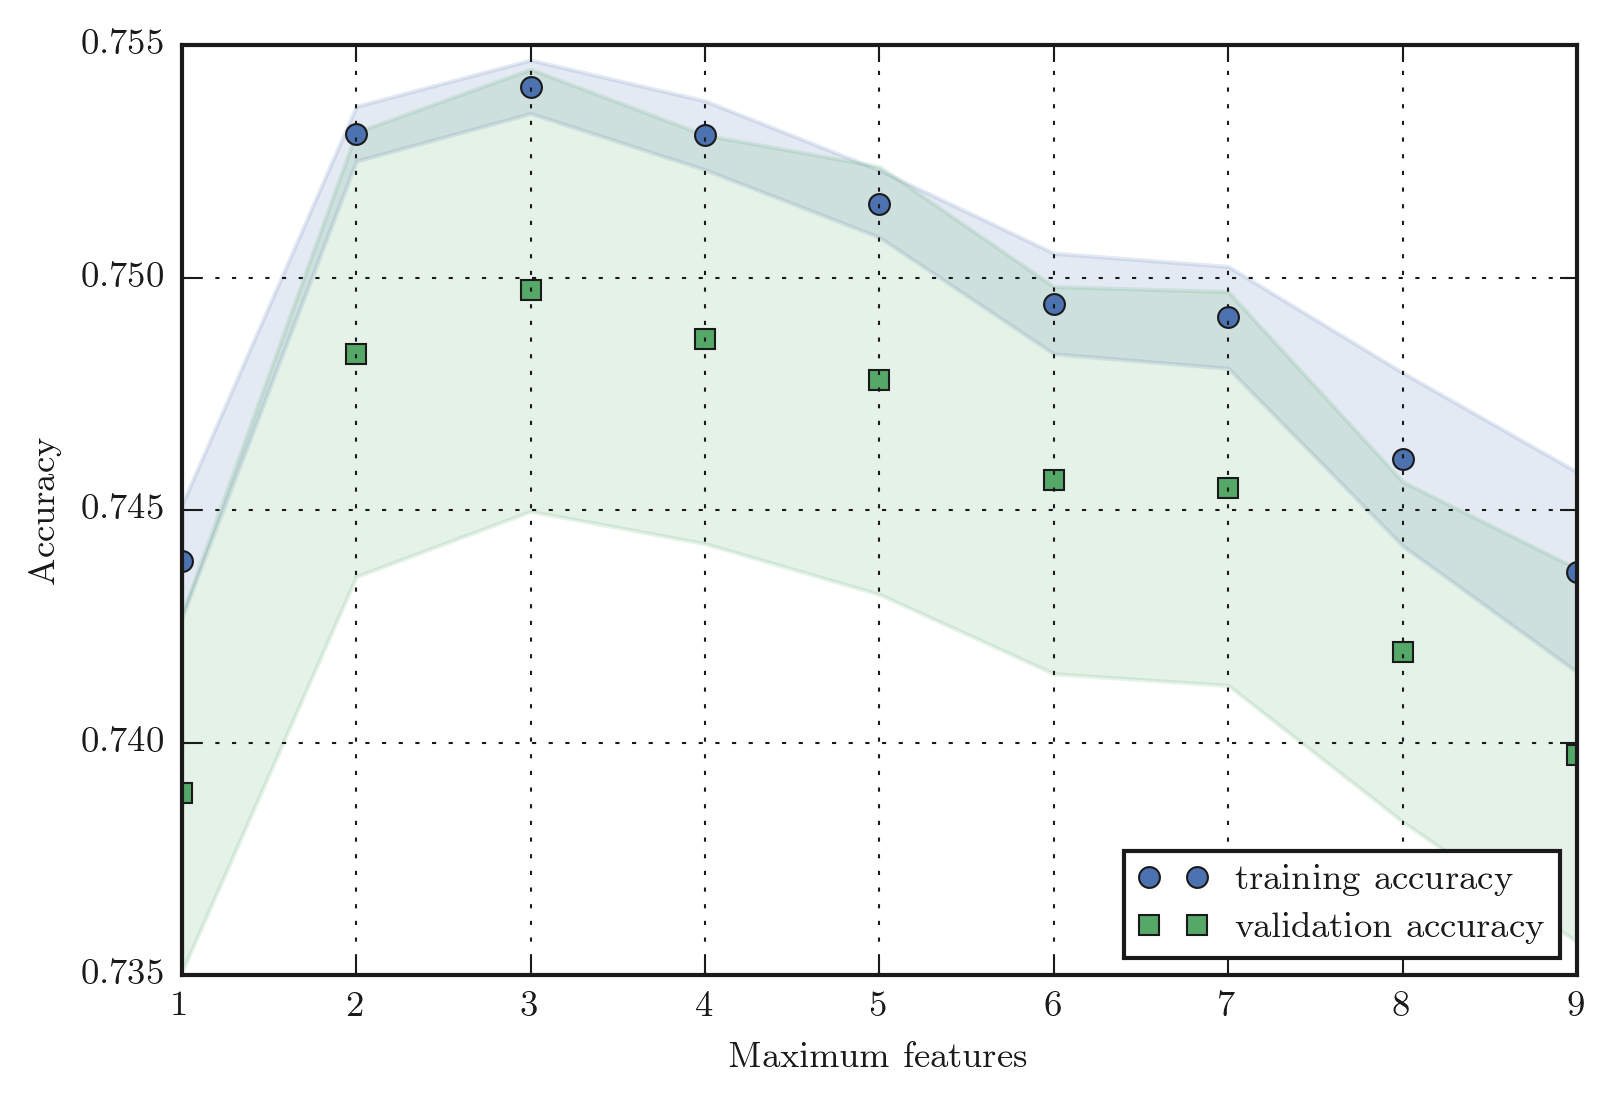

In [10]:
pipeline = comp.get_pipeline('RF')
param_range = np.arange(1, X_train.shape[1])
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=y_train, 
                param_name='classifier__max_features', 
                param_range=param_range,
                cv=10,
                verbose=2,
                n_jobs=20)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='b', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='b')

plt.plot(param_range, test_mean, 
         color='g', linestyle='None', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='g')

plt.grid()
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Maximum features')
plt.ylabel('Accuracy')
# plt.ylim([0.8, 1.0])
# plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-validation_curve_min_samples_leaf.png', dpi=300)
plt.show()

### Minimum samples in leaf node

[CV] classifier__min_samples_leaf=1 ..................................
[CV] classifier__min_samples_leaf=26 .................................
[CV] classifier__min_samples_leaf=51 .................................
[CV] classifier__min_samples_leaf=76 .................................
[CV] classifier__min_samples_leaf=101 ................................
[CV] classifier__min_samples_leaf=126 ................................
[CV] classifier__min_samples_leaf=151 ................................
[CV] classifier__min_samples_leaf=176 ................................
[CV] classifier__min_samples_leaf=201 ................................
[CV] classifier__min_samples_leaf=226 ................................
[CV] classifier__min_samples_leaf=251 ................................
[CV] classifier__min_samples_leaf=276 ................................
[CV] classifier__min_samples_leaf=301 ................................
[CV] classifier__min_samples_leaf=326 ................................
[CV] c

[Parallel(n_jobs=20)]: Done  80 out of 160 | elapsed:  2.5min remaining:  2.5min


[CV] ....................... classifier__min_samples_leaf=276 -   0.5s
[CV] classifier__min_samples_leaf=101 ................................
[CV] ....................... classifier__min_samples_leaf=226 -   0.4s
[CV] classifier__min_samples_leaf=126 ................................
[CV] ....................... classifier__min_samples_leaf=126 -   0.3s
[CV] classifier__min_samples_leaf=151 ................................
[CV] ....................... classifier__min_samples_leaf=101 -   3.8s
[CV] classifier__min_samples_leaf=176 ................................
[CV] ....................... classifier__min_samples_leaf=101 -   0.4s
[CV] classifier__min_samples_leaf=201 ................................
[CV] ....................... classifier__min_samples_leaf=126 -   0.4s
[CV] classifier__min_samples_leaf=226 ................................
[CV] ....................... classifier__min_samples_leaf=176 -   1.2s
[CV] classifier__min_samples_leaf=251 ................................
[CV] .

[Parallel(n_jobs=20)]: Done 160 out of 160 | elapsed:  4.7min finished


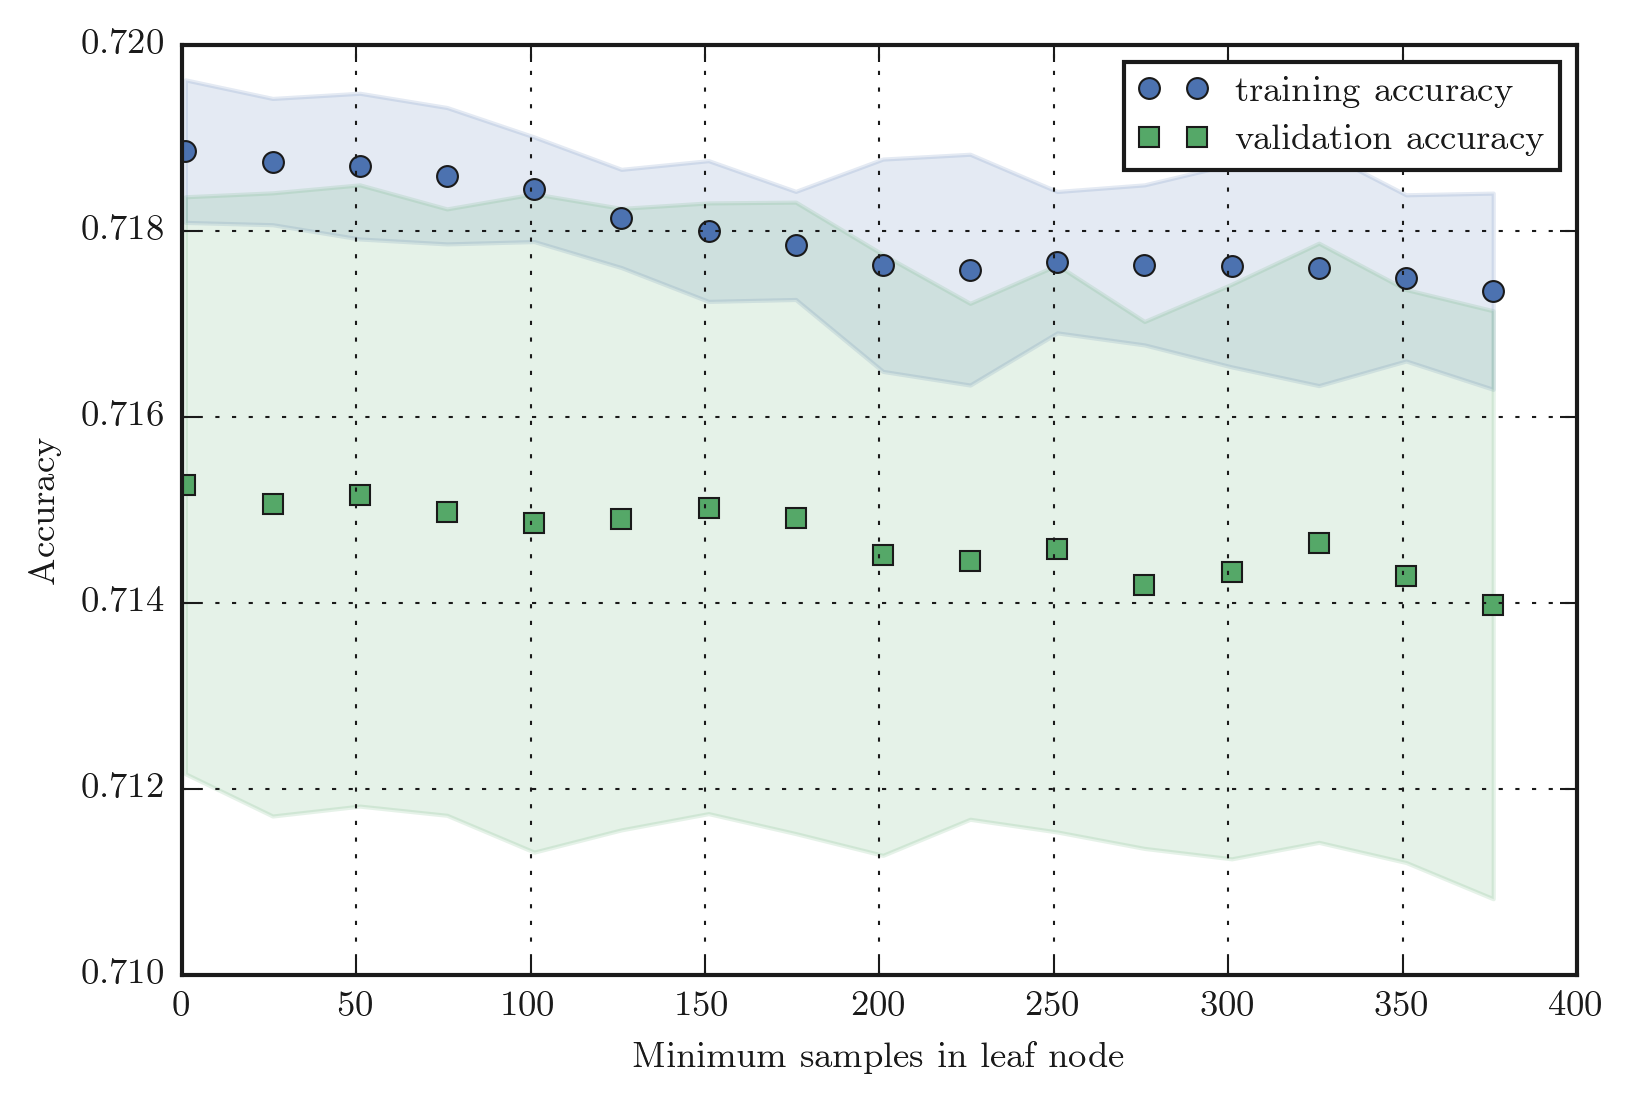

In [7]:
pipeline = comp.get_pipeline('RF')
param_range = np.arange(1, 400, 25)
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=y_train, 
                param_name='classifier__min_samples_leaf', 
                param_range=param_range,
                cv=10,
                verbose=2,
                n_jobs=20)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='b', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='b')

plt.plot(param_range, test_mean, 
         color='g', linestyle='None', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='g')

plt.grid()
# plt.xscale('log')
plt.legend()
plt.xlabel('Minimum samples in leaf node')
plt.ylabel('Accuracy')
# plt.ylim([0.8, 1.0])
# plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-validation_curve_min_samples_leaf.png', dpi=300)
plt.show()

## KS-test tuning

### Maximum depth

In [7]:
comp_list = ['light', 'heavy']
max_depth_list = np.arange(1, 16)
pval_comp = defaultdict(list)
ks_stat = defaultdict(list)
kf = KFold(n_splits=10)
fold_num = 0
for train_index, test_index in kf.split(X_train):
    fold_num += 1
    print('\r')
    print('Fold {}: '.format(fold_num), end='')
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    pval_maxdepth = defaultdict(list)
    print('max_depth = ', end='')
    for max_depth in max_depth_list:
        print('{}...'.format(max_depth), end='')
        pipeline = comp.get_pipeline('RF')
        pipeline.named_steps['classifier'].set_params(max_depth=max_depth)
        pipeline.fit(X_train_fold, y_train_fold)
        test_probs = pipeline.predict_proba(X_test_fold)
        train_probs = pipeline.predict_proba(X_train_fold)
        for class_ in pipeline.classes_:
            pval_maxdepth[le.inverse_transform(class_)].append(stats.ks_2samp(test_probs[:, class_], train_probs[:, class_])[1])
    for composition in comp_list:
        pval_comp[composition].append(pval_maxdepth[composition])
pval_sys_err = {key: np.std(pval_comp[key], axis=0) for key in pval_comp}
pval = {key: np.mean(pval_comp[key], axis=0) for key in pval_comp}


Fold 1: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 2: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 3: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 4: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 5: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 6: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 7: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 8: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 9: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 10: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...

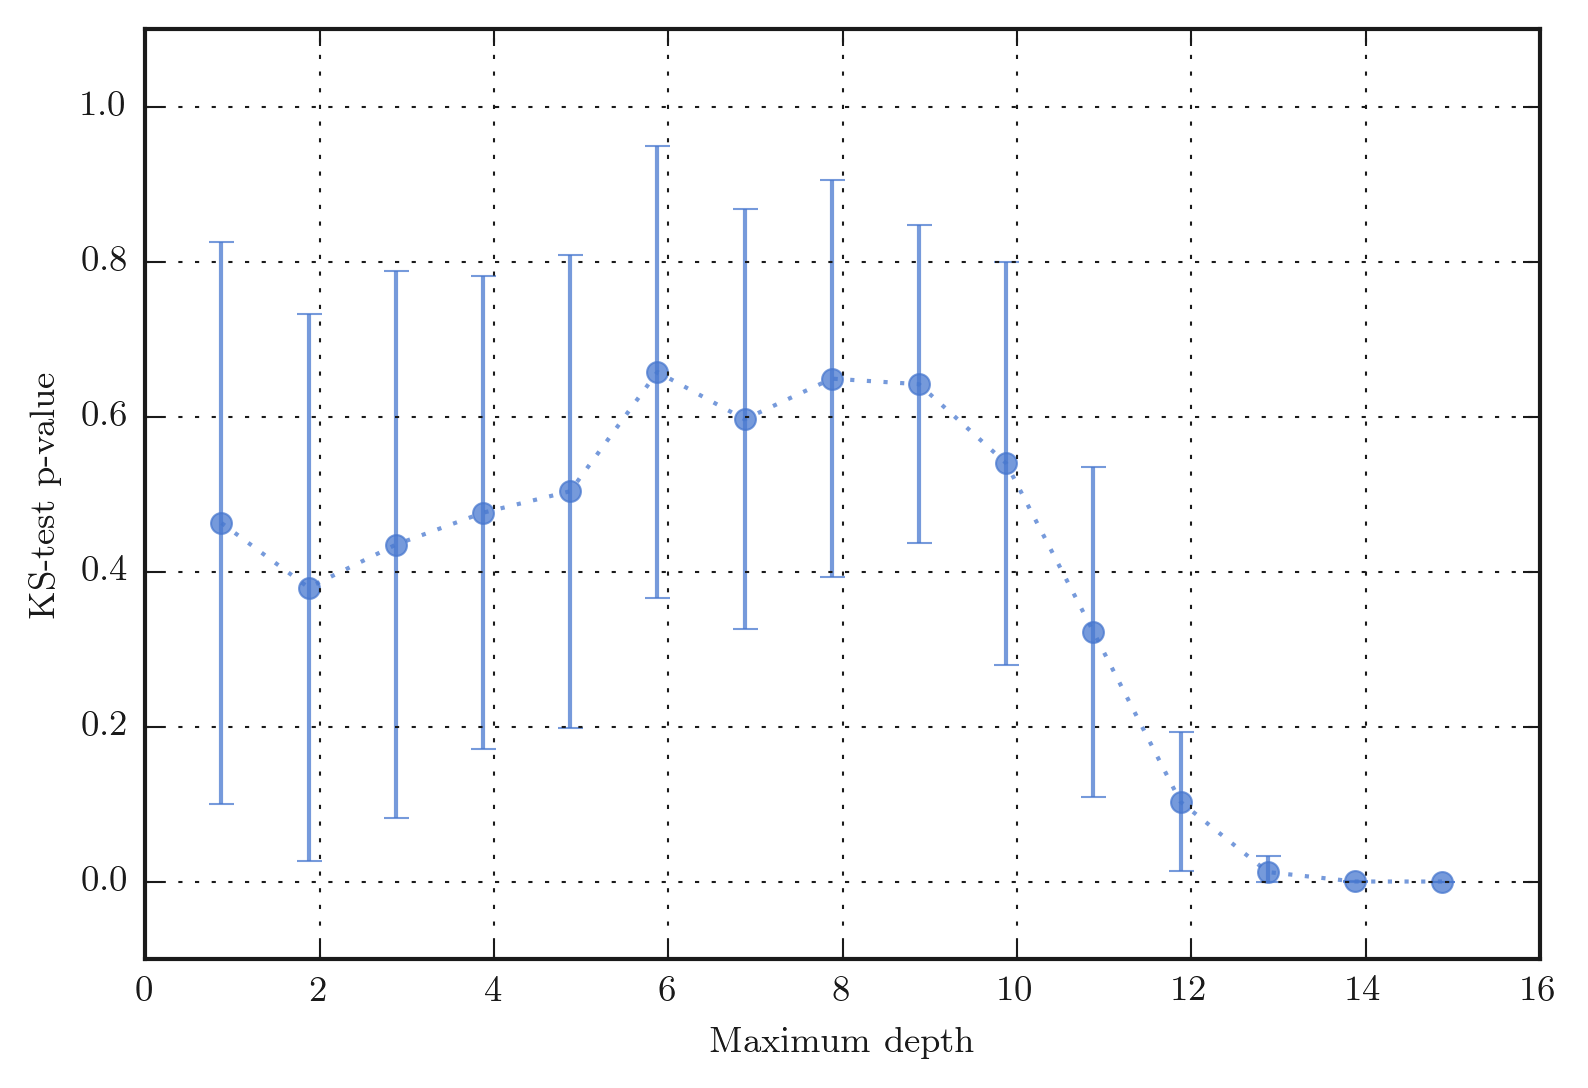

In [8]:
comp_list = ['light']
fig, ax = plt.subplots()
for composition in comp_list:
    upper_err = np.copy(pval_sys_err[composition])
    upper_err = [val if ((pval[composition][i] + val) < 1) else 1-pval[composition][i] for i, val in enumerate(upper_err)]
    lower_err = np.copy(pval_sys_err[composition])
    lower_err = [val if ((pval[composition][i] - val) > 0) else pval[composition][i] for i, val in enumerate(lower_err)]
    if composition == 'light':
        ax.errorbar(max_depth_list -0.25/2, pval[composition],
                    yerr=[lower_err, upper_err],
                    marker='.', linestyle=':',
                    label=composition, alpha=0.75)
    if composition == 'heavy':
        ax.errorbar(max_depth_list + 0.25/2, pval[composition],
                    yerr=[lower_err, upper_err],
                    marker='.', linestyle=':',
                    label=composition, alpha=0.75)
plt.ylabel('KS-test p-value')
plt.xlabel('Maximum depth')
plt.ylim([-0.1, 1.1])
# plt.legend()
plt.grid()
plt.show()

In [20]:
pval

{'heavy': array([  7.16894934e-01,   6.76231102e-01,   6.75417490e-01,
          5.46730739e-01,   5.68780852e-01,   4.40231335e-01,
          4.82516082e-01,   5.14720962e-01,   5.16080561e-01,
          5.00066822e-01,   3.96053875e-01,   2.12820818e-01,
          3.65621330e-02,   2.58837771e-04,   1.52490663e-07]),
 'light': array([  7.16894934e-01,   6.76231102e-01,   6.75417490e-01,
          5.46730739e-01,   5.68780852e-01,   4.40231335e-01,
          4.82516082e-01,   5.14720962e-01,   5.16080561e-01,
          5.00066822e-01,   3.96053875e-01,   2.12820818e-01,
          3.65621330e-02,   2.58837771e-04,   1.52490663e-07])}

### Minimum samples in leaf node

In [ ]:
comp_list = np.unique(df['MC_comp_class'])
min_samples_list = np.arange(1, 400, 25)
pval = defaultdict(list)
ks_stat = defaultdict(list)
print('min_samples_leaf = ', end='')
for min_samples_leaf in min_samples_list:
    print('{}...'.format(min_samples_leaf), end='')
    pipeline = comp.get_pipeline('RF')
    params = {'max_depth': 4, 'min_samples_leaf': min_samples_leaf}
    pipeline.named_steps['classifier'].set_params(**params)
    pipeline.fit(X_train, y_train)
    test_probs = pipeline.predict_proba(X_test)
    train_probs = pipeline.predict_proba(X_train)
    for class_ in pipeline.classes_:
        pval[le.inverse_transform(class_)].append(stats.ks_2samp(test_probs[:, class_], train_probs[:, class_])[1])
fig, ax = plt.subplots()
for composition in pval:
    ax.plot(min_samples_list, pval[composition], linestyle='-.', label=composition)
plt.ylabel('KS-test p-value')
plt.xlabel('Minimum samples leaf node')
plt.legend()
plt.grid()
plt.show()

### Maximum depth for various minimum samples in leaf node

min_samples_leaf = 1...100...200...300...

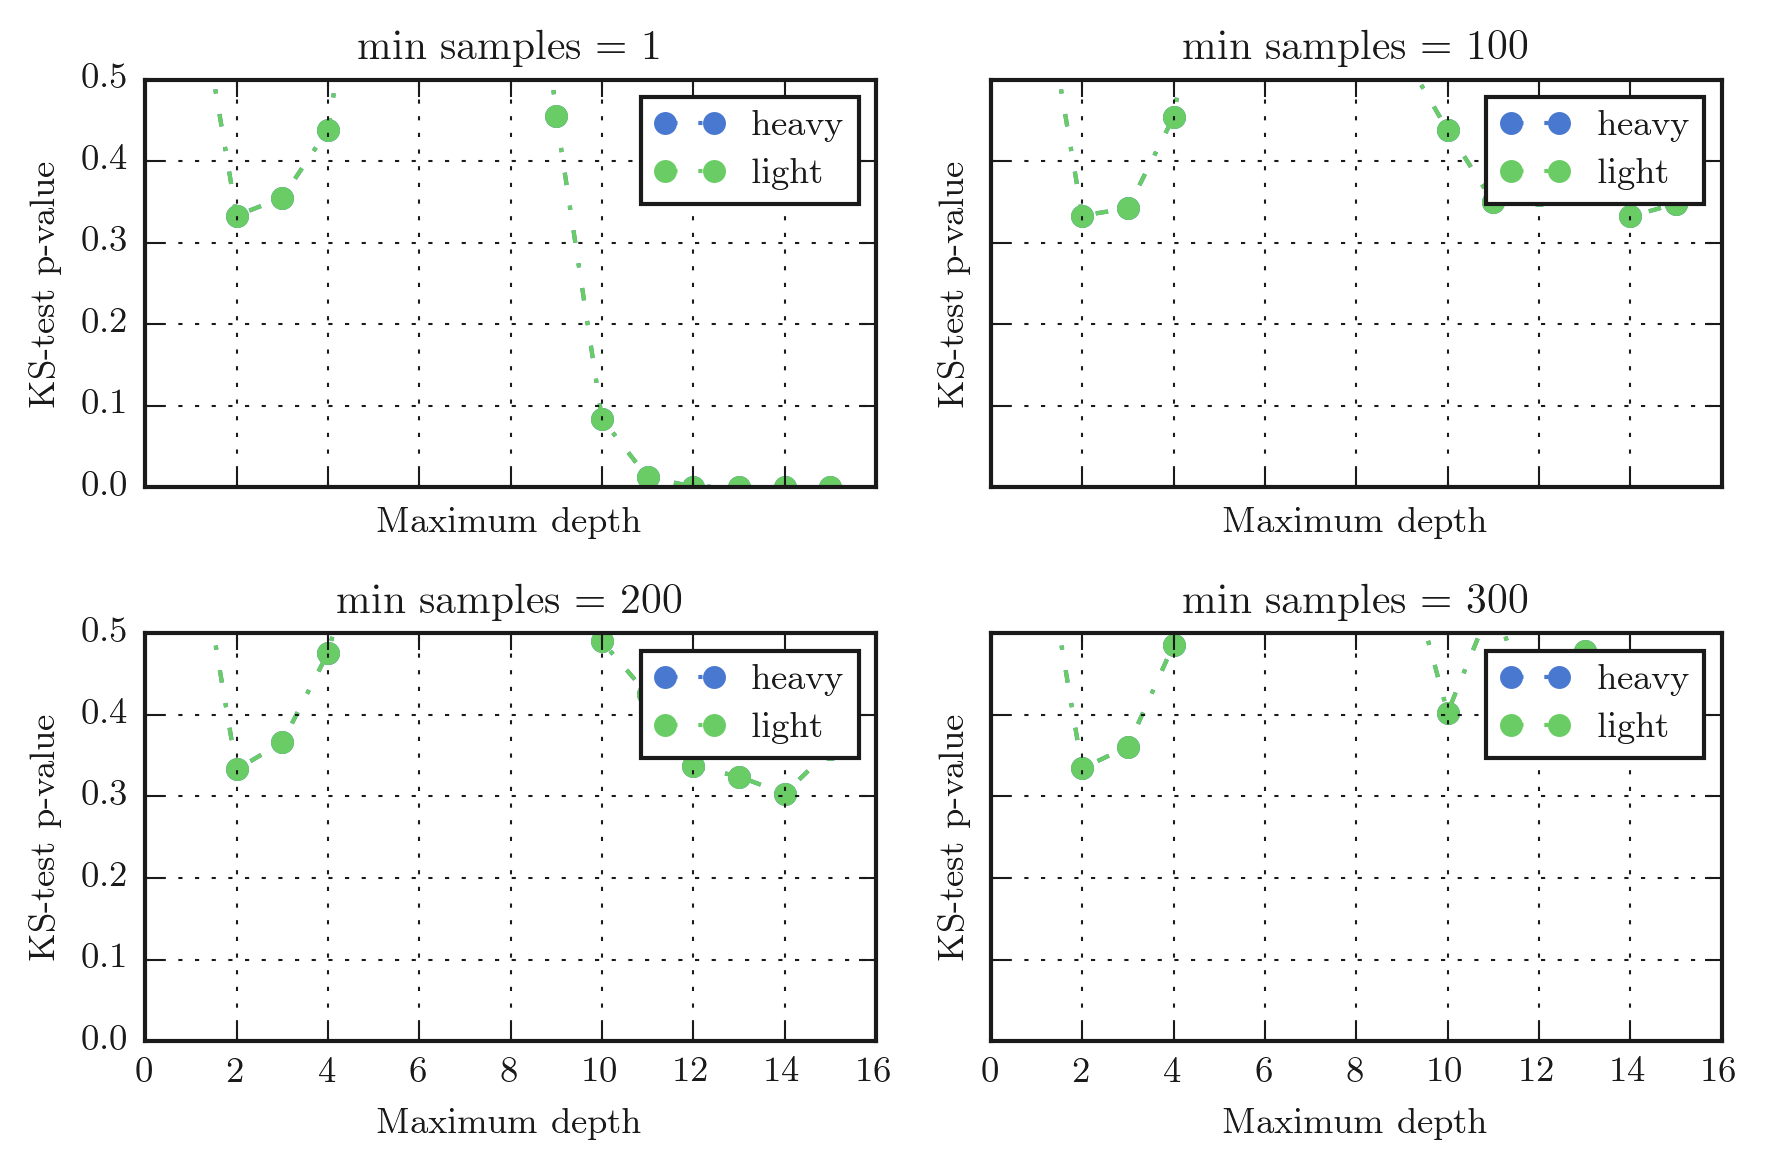

In [11]:
# comp_list = np.unique(df['MC_comp_class'])
comp_list = ['light']
min_samples_list = [1, 25, 50, 75]
min_samples_list = [1, 100, 200, 300]
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
print('min_samples_leaf = ', end='')
for min_samples_leaf, ax in zip(min_samples_list, axarr.flatten()):
    print('{}...'.format(min_samples_leaf), end='')
    max_depth_list = np.arange(1, 16)
    pval = defaultdict(list)
    ks_stat = defaultdict(list)
    for max_depth in max_depth_list:
        pipeline = comp.get_pipeline('RF')
        params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}
        pipeline.named_steps['classifier'].set_params(**params)
        pipeline.fit(X_train, y_train)
        test_probs = pipeline.predict_proba(X_test)
        train_probs = pipeline.predict_proba(X_train)
        for class_ in pipeline.classes_:
            pval[le.inverse_transform(class_)].append(stats.ks_2samp(test_probs[:, class_], train_probs[:, class_])[1])
    for composition in pval:
        ax.plot(max_depth_list, pval[composition], linestyle='-.', label=composition)
    ax.set_ylabel('KS-test p-value')
    ax.set_xlabel('Maximum depth')
    ax.set_title('min samples = {}'.format(min_samples_leaf))
    ax.set_ylim([0, 0.5])
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()